In [22]:
import os
import pdb
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
from xgboost import plot_tree
import matplotlib.pyplot as plt
from os.path import join as pjoin
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics,preprocessing,linear_model,tree
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
# pd.read_hdf('../data/GSE145926_RAW/GSM4339769_C141_filtered_feature_bc_matrix.h5')

In [ ]:
import h5py

In [ ]:
path = '../data/GSE145926_RAW/GSM4339769_C141_filtered_feature_bc_matrix.h5'

In [ ]:
f = h5py.File(path, 'r')

In [ ]:
for key in f.keys():
    print(key)

In [ ]:
# group = f['matrix']

# data = []
# for key in group.keys():
#     print(key)
#     data.append(group[(key)].value)

In [ ]:
group.keys()

In [ ]:
a = group[('features')]
try:
    print(a[()])
except:
    print(a.keys())

In [ ]:
a = group[('barcodes')][()]
a.shape

In [ ]:
a = group[('data')][()]
a.shape

In [ ]:
a = group[('indices')][()]
a.shape

In [ ]:
a = group[('indptr')][()]
a.shape

In [ ]:
a = group[('shape')][()]
a

In [ ]:
a.keys()
a['name'][()]

In [23]:
# def preprocess_time_series():
#     # read 375 patients' data, set first column(PATIENT_ID) and second column(RE_DATE) as index (check time)
#     data = pd.read_excel('data/time_series_375_prerpocess_en.xlsx', index_col=[0, 1])
#     data = data.dropna(thresh=6) #drop out 14 rows
#     data.to_parquet('data/time_series_375.parquet')
#     # read 100 patients' data, set first column (PATIENT_ID) and second column (RE_DATE) as index
#     data = pd.read_excel('data/time_series_test_110_preprocess_en.xlsx', index_col=[0, 1])
#     data.to_parquet('data/time_series_test_110.parquet')

# # preprocess_time_series()

def preprocessTimeSeries(path, drop=False):
    '''
    read excel file and preprocess times series using parquet, if drop is true then drop NA rows
    '''
    data = pd.read_excel(path, index_col=[0, 1])
    if drop:
        data = data.dropna(thresh=6) #drop out 14 rows
    data.to_parquet(path.split('.')[0]+'.parquet')
    
# preprocessTimeSeries('data/time_series_375_prerpocess_en.xlsx',True)
# preprocessTimeSeries('data/time_series_test_110_preprocess_en.xlsx')

In [24]:
def readTimeSeries(path,col=None):
    if col == None:
        data = pd.read_parquet(path)
    else:
        data = pd.read_parquet(path)[col]
    return data

# col = ['age', 'gender','Lactate dehydrogenase','High sensitivity C-reactive protein','(%)lymphocyte',
#        'Discharge time', 'outcome']
# data1 = readTimeSeries('data/time_series_375_prerpocess_en.parquet',col)
col = ['Lactate dehydrogenase','High sensitivity C-reactive protein','(%)lymphocyte',
       'Discharge time', 'outcome']
# data1 = readTimeSeries('data/time_series_375_prerpocess_en.parquet',col)
# data2 = readTimeSeries('data/time_series_test_110_preprocess_en.parquet',col)
data1 = readTimeSeries('data/time_series_375_prerpocess_en.parquet')
data2 = readTimeSeries('data/time_series_test_110_preprocess_en.parquet')

In [25]:
def concatenateData(data1: pd.DataFrame, data2: pd.DataFrame):
    '''
    concatenate two datasets
    PATIENT_ID starts from 1, needs to reset index in order to aviod duplicate

    Arg:
        data1: DataFrame
        data2: DataFrame
    Return:
        data
    
    '''
    data2 = data2.reset_index()
    data2['PATIENT_ID'] += data1.index[-1][0]
    data2 = data2.set_index(['PATIENT_ID', 'RE_DATE'])
    return data1.append(data2)

In [26]:
class Metrics:
    def __init__(self, report=None, acc=None, f1=None, conf_mat=None):
        self.y_trues  = []
        self.y_preds  = []
        
        # list or None. every: each; 'overall': print all
        if isinstance(report, list):
            self.report = report
        else:
            self.report = [report]

        if isinstance(acc, list):
            self.acc = acc
        else:
            self.acc = [acc]

        if isinstance(f1, list):
            self.f1 = f1
        else:
            self.f1 = [f1]

        if isinstance(conf_mat, list):
            self.conf_mat = conf_mat
        else:
            self.conf_mat = [conf_mat]

    def record(self, y_true, y_pred):
        self.y_trues.append(y_true)
        self.y_preds.append(y_pred)
        return self

    def clear(self):
        self.y_trues = []
        self.y_preds = []
        return self

    def print_metrics(self):
        """
        :param report:
        :param acc:
        :param f1:
        :param conf_mat:
        :return:
        """
        # Loop: 'every'
        acc_values, f1_values = [], []
        single_fold = True if len(self.y_trues) == 1 else False
        for i, (y_true, y_pred) in enumerate(zip(self.y_trues, self.y_preds)):
            assert (y_true.ndim == 1) and (y_pred.ndim == 1)
            print(f'\n========================  {i+1}  ========================>')

            # Classification_report
            if (self.report is not None) and ('every' in self.report):
                print(metrics.classification_report(y_true, y_pred))

            # Accuracy_score
            a_v = metrics.accuracy_score(y_true, y_pred)
            acc_values.append(a_v)
            if (self.acc is not None) and ('every' in self.acc):
                print(f"accuracy: {a_v:.05f}")

            # F1_score
            f1_v = metrics.f1_score(y_true, y_pred, average='macro')
            f1_values.append(f1_v)
            if (self.f1 is not None) and ('every' in self.f1):
                print(f"F1: {f1_v:.05f}")

            # Confusion_matrix
            if (self.conf_mat is not None) and ('every' in self.conf_mat):
                print(f"Confusion Matrix：\n{metrics.confusion_matrix(y_true, y_pred)}")

        # 'Overall'
        print('\n======================== all ========================>')
        y_true = np.hstack(self.y_trues)
        y_pred = np.hstack(self.y_preds)

        # Classification_report
        if (self.report is not None) and ('overall' in self.report):
            print(metrics.classification_report(y_true, y_pred))
        # Accuracy_score
        if (self.acc is not None) and ('overall' in self.acc):
            if single_fold:
                print(f"accuracy：\t{acc_values[0]: .04f}")
            else:
                print(f"accuracy：\t{np.mean(acc_values): .04f}/ \
                      {'  '.join([str(a_v.round(2)) for a_v in acc_values])}")
        # F1_score
        if (self.f1 is not None) and ('overall' in self.f1):
            if single_fold:
                print(f"F1-score：\t{f1_values[0]: .04f}")
            else:
                print(f"F1 score：\t{np.mean(f1_values): .04f}/ \
                      {'  '.join([str(f1_v.round(2)) for f1_v in f1_values])}")

        # Confusion_matrix
        if (self.conf_mat is not None) and ('overall' in self.conf_mat):
            print(f"Confusion Matrix：\n{confusion_matrix(y_true, y_pred)}")

In [27]:
def mergeDataBySlidingWindow(data, nDays=1,dropna=True,subset=col[:3],timeForm='diff'):
    """滑窗合并数据

    :param data: 时间序列数据，一级行索引为 PATIENT_ID, 二级行索引为 RE_DATE
    :param n_days: 窗口长度
    :param dropna: 滑窗合并后还缺失的是否删掉
    :param subset: pd.DataFrame().dropna() 参数                   Note: 新参数!
    :param time_form: 返回数据的时间索引，'diff' or 'timestamp'
    :return: 合并后的数据，一级行索引为 PATIENT_ID, 二级行索引为 t_diff or RE_DATE, 取决于"time_form"
    """
    #根据PATIENT_ID排序
    data = data.reset_index(level=1)
    # dt.normalize() 取Discharge time的天数
    # 距离出院时长        Note: 去掉了Discharge time和检测时间的时分秒，因为我觉得以 00:00:00 为分界点更合适
    t_diff = data['Discharge time'].dt.normalize() - data['RE_DATE'].dt.normalize()
    # 滑窗取整的依据。即nn_days天内的会取整成为同一个数值，后面通过groupby方法分组
    data['t_diff'] = t_diff.dt.days.values // nDays * nDays
    #
    data = data.set_index('t_diff', append=True)

    # 滑窗合并。对['PATIENT_ID', 't_diff']groupby，相当于双循环。遍历所有病人与病人的所有窗口
    # 因为之前对data排序，因此每个病人t_diff会是从大到小的排序,ffill()是向上一行插值，因此相当于是向旧日期插值
    # last()是每一组取最后一行，因此即取每个病人对应窗口的最后一次数据，（也一定是最全的）。
    # last(）自带排序。取完last后会按照索引升序排列
    data = (data.groupby(['PATIENT_ID', 't_diff']).ffill()
                .groupby(['PATIENT_ID', 't_diff']).last())
    # 去掉缺失样本
    if dropna:
        data = data.dropna(subset=subset)  # Note: 这里对缺失值进行了 dropna(), 而不是 fillna(-1)

    # 更新二级索引。（其实timestamp在本论文的中没用到）
    if timeForm == 'timestamp':
        data = (data.reset_index(level=1, drop=True)
                    .set_index('RE_DATE', append=True))
    elif timeForm == 'diff':
        data = data.drop(columns=['RE_DATE'])

    return data

In [28]:
def plotHist(ax,data,**kwargs):
    params = dict(density=True,stacked=True,histtype='barstacked',label=['die','survial'],
                  xlabel='Age',ylabel='Percentage',)
    params.update(kwargs)
    # plt.rcParams.update({'font.size': 25})
    bins = np.linspace(0,100,21,dtype=int)
    hist = ax.hist(data,bins=bins,density=params.get('density'),stacked=params.get('stacked'),
                   histtype=params.get('histtype'),alpha=0.75,label=params.get('label'))
    kde = stats.gaussian_kde(np.concatenate(data, axis=None))
    ax.plot(bins,kde.pdf(bins),label='KDE',lw=3) # kernel density estimation
    ax.set(xlabel=params.get('xlabel'),ylabel=params.get('ylabel'),xlim=(-1,101))

    for i,rect in enumerate(ax.patches):
    #     height = rect.get_height()
    #     ax.annotate(f'{np.round(height,4)}', xy=(rect.get_x()+rect.get_width()/2,height), 
    #                 xytext=(0,5),textcoords='offset points',ha='center', va='bottom')
        width, height = rect.get_width(), rect.get_height()
        if height <= 0:
            continue
        x, y = rect.get_xy() 
        ax.text(x+width/2,y+height/2, '{:.4f}'.format(height), 
                horizontalalignment='center', verticalalignment='top')
    ax.set(xticks=bins)
    ax.legend(fontsize='large')
    fig.subplots_adjust(wspace=0,hspace=0)
    plt.show()

In [ ]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [ ]:
a = 0
for i in range(1,376):
    try:
        a += data1.xs(i, level='PATIENT_ID')['age'].values.mean()
    except KeyError:
        print(i)
a

In [ ]:
data = mergeDataBySlidingWindow(data1, nDays=1,dropna=False,subset=None,timeForm='diff')
# data

In [ ]:
data.shape

In [ ]:
col = ['age', 'gender','Lactate dehydrogenase','High sensitivity C-reactive protein','(%)lymphocyte',
       'Discharge time', 'outcome']

In [ ]:
b = []
a = []
for i in range(1,376):
    try:
        a.append(data.loc[i][['age','gender','outcome']].values[0])
    except KeyError:
        b.append(i)
c = np.vstack(a)
x = np.unique(c[:,0])
y = np.zeros((2,)+x.shape)
for i, n in enumerate(x):
    total = c[np.where(c[:,0]==n)[0],1]
    count = np.count_nonzero(total)
    y[0,i] = total.shape[0] - count
    y[1,i] = count

In [ ]:
# plt.rcParams.update({'font.size': 25})
bins = np.linspace(0,100,21,dtype=int)
fig,ax=plt.subplots(figsize=(30,20),dpi=300)
hist = ax.hist((c[np.where((c[:,1]==1)&(c[:,2]==1))[0],0],
                c[np.where((c[:,1]==2)&(c[:,2]==1))[0],0],
                c[np.where((c[:,1]==1)&(c[:,2]==0))[0],0],
                c[np.where((c[:,1]==2)&(c[:,2]==0))[0],0]),
#                density=True,stacked=True,
               bins=bins,
               histtype='barstacked',alpha=0.75,label=['M die','F die','M survial','F survial'])
kde = stats.gaussian_kde(c[:,0])
ax.plot(bins,kde.pdf(bins)*kde.n*np.diff(bins)[0],label='KDE',lw=3)
ax.set(xlabel='Age',ylabel='counts',xlim=(-1,101))

for i,rect in enumerate(ax.patches):
#     height = rect.get_height()
#     ax.annotate(f'{np.round(height,4)}', xy=(rect.get_x()+rect.get_width()/2,height), 
#                 xytext=(0,5),textcoords='offset points',ha='center', va='bottom') 
    width, height = rect.get_width(), rect.get_height()
    if height <= 0:
        continue
    x, y = rect.get_xy() 
    ax.text(x+width/2,y+height/2,'{:3.0f}'.format(height), 
            horizontalalignment='center', verticalalignment='center')
ax.set(xticks=bins)
# ax.set_yticklabels(labels=ax.get_yticks()*100)
ax.legend(fontsize='large')
# fig.subplots_adjust(wspace=0,hspace=0)
fig.savefig('age&gender.jpeg')
plt.show()


I have reviewed your visualizations. Some of them are quite nice, and some need clarifications.

1. need to be more specific about training and testing samples. How were accuracies calculated?

2. Among the ratios, which were important? How many of them seem to be enough for predicting mortality?

3. Can the analysis be done separately for different age groups (young, middle age, old) and different disease severity (general, severe, critical)?

4. In the decision trees, the labels of the nodes and edges are not clear to me.  These should be simplified so that biologists and doctors can understand. See Figure 2 of the original paper. This is an important visualization.

5. In the neural network approach, instead of taking only age and gender can you consider other predictors also? Can you compare with the observed proportion of deaths in the different age groups?

6. The 3-d plots are also interesting. Does the clustering algorithm perform well? What are the proportion of misclassification?

7. Was the severity status determined once at the beginning? if not, can we predict the severity status (mild, severe, critical) based on the protein measurements and their ratios of the initial blood sample?

In [ ]:
fig,ax=plt.subplots(figsize=(30,20),dpi=300)
plt.rcParams.update({'font.size': 18})
# plotHist(ax,c[np.where(c[:,1]==0)[0],0],label='survial')
# fig,ax=plt.subplots(figsize=(30,20),dpi=300)
# plotHist(ax,c[np.where(c[:,1]==1)[0],0],label='die')
# fig,ax=plt.subplots(figsize=(30,20),dpi=300)
plotHist(ax,(c[np.where(c[:,1]==1)[0],0],c[np.where(c[:,1]==0)[0],0]))

In [ ]:
for i,data in enumerate([data1, data2, concatenateData(data1,data2)]):
    data = mergeDataBySlidingWindow(data, nDays=1,dropna=True,subset=col[:3],timeForm='diff')
    classifier = tree.DecisionTreeClassifier()
    if i == 0:
        classifier.fit(data1[col[:3]].values, data1[col[-1]].values)
    
    data['pred'] = data.apply()
    resultMetric = Metrics(*(['overall']*4))

In [ ]:
col = ['age', 'gender','Lactate dehydrogenase','High sensitivity C-reactive protein','(%)lymphocyte',
       'Discharge time', 'outcome']
data = mergeDataBySlidingWindow(data1, nDays=1,dropna=True,subset=col[:3],timeForm='diff')
data3 = mergeDataBySlidingWindow(data2, nDays=1,dropna=True,subset=col[:3],timeForm='diff')
X_train=data[col[:3]].values
X_test=data3[col[:3]].values
y_train = data[col[-1]].values
y_true = data3[col[-1]].values

In [ ]:
classifiers = [KNeighborsClassifier(2),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier()]
names = ['knn','Random Forest','MLP','AdaBoost']
for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print('='*20+name+'='*20)
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.classification_report(y_true, y_pred))
    print(metrics.accuracy_score(y_true, y_pred))
    print('='*50)

In [29]:
# col = ['age', 'gender','Lactate dehydrogenase','High sensitivity C-reactive protein','(%)lymphocyte',
#        'serum sodium','Discharge time', 'outcome']
col = ['Lactate dehydrogenase','High sensitivity C-reactive protein','(%)lymphocyte','outcome']
data = mergeDataBySlidingWindow(data1, nDays=1,dropna=True,subset=col[:-1],timeForm='diff')
data3 = mergeDataBySlidingWindow(data2, nDays=1,dropna=True,subset=col[:-1],timeForm='diff')

In [ ]:
'''
k fold 07/11/2020
'''
all_histories = []
k = 4
X_train = data[col[:-1]].values
y_train = data[col[-1]]
X_val = data1[col[:-1]].values
y_val = data1[col[-1]]
num_val_samples = data.shape[0]//k
for i in range(k):
    print('processing fold #',i)
    ind = i*num_val_samples
    val_data = X_train[ind:ind+num_val_samples]
    val_targets = y_train[ind:ind+num_val_samples]
    partial_train_data = np.concatenate([X_train[:ind],X_train[ind+num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train[:ind],y_train[ind+num_val_samples:]],axis=0)
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(partial_train_data,partial_train_targets)
    y_pred=classifier.predict(X_val)
    print(metrics.confusion_matrix(y_val, y_pred))
    print(metrics.classification_report(y_val, y_pred))
    print('='*50)
    all_histories.append(metrics.accuracy_score(y_val, y_pred))
np.sum(all_histories)/k

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data3[col[:5]].values,data3[col[-1]],
                                                  test_size=0.3, random_state=6)

In [38]:
X_train,y_train = data[col[:-1]],data[col[-1]]
X_val,y_val = data3[col[:-1]],data3[col[-1]]

In [39]:
classifier = tree.DecisionTreeClassifier()

In [40]:
classifier.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
fig, ax = plt.subplots(figsize=(40,50),dpi=300)
plotT = tree.plot_tree(classifier,feature_names=col[:-1],class_names=True,filled=True,
                       rounded=True,ax=ax,fontsize=5)
ax.text(0,1,'Right:No, Left:Yes\nFeatures:\n1.{},\n2.{},\n3.{}\n \
            outcome: die or survial'.format(*col[:-1]),fontsize=50,
        horizontalalignment='center',verticalalignment='center')
fig.savefig('tree.jpeg')
plt.show()

In [41]:
y_pred=classifier.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred))
print(metrics.accuracy_score(y_val, y_pred))

[[171  11]
 [ 15  54]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       182
           1       0.83      0.78      0.81        69

    accuracy                           0.90       251
   macro avg       0.88      0.86      0.87       251
weighted avg       0.90      0.90      0.90       251

0.896414342629482


In [97]:
# fig, ax = plt.subplots(figsize=(3,3),dpi=300)
# plt.rcParams.update({'font.size': 5})
# pltcm = metrics.plot_confusion_matrix(classifier,X_val,y_val,values_format='d',
#                               labels=[0,1],display_labels=['surival','die'],ax=ax)
# pltcm.ax_.set_title('accuracy: %s %%'% np.round(metrics.accuracy_score(y_val, y_pred)*100,2))
# pltcm.ax_.text(-0.5,-0.3,'Features:\n1.{},\n2.{},\n3.{}'.format(*col[:-1]),
#         horizontalalignment='center',verticalalignment='center')
# pltcm.ax_.set_aspect('auto')
# # ax.set_xlabel('Predict Label',fontdict={'size':font})
# # ax.set_ylabel('True Label',fontdict={'size':font})
# plt.tight_layout(h_pad=1)
# fig.savefig('confusion_matrix.jpeg')
# plt.show()

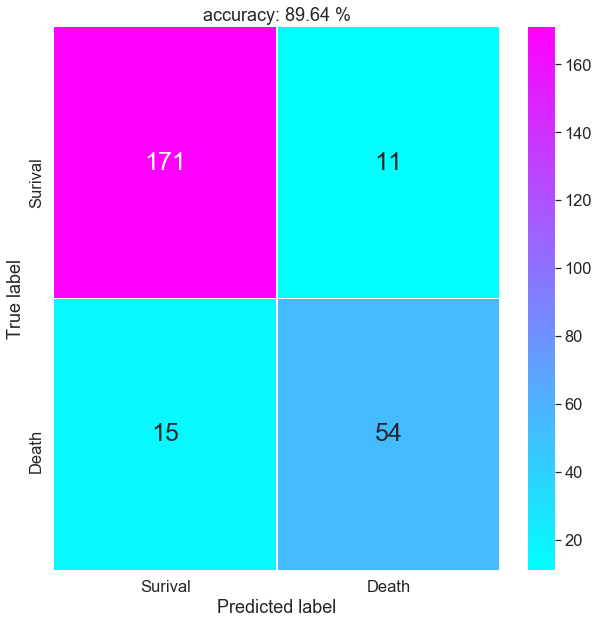

In [126]:
confusionMatrix = metrics.confusion_matrix(y_val, y_pred)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
sns.set(font_scale=1.5)
ax = sns.heatmap(confusionMatrix,cmap='cool',annot=True,cbar=True,annot_kws={'size':25},
                 linewidths=.5,fmt='d',
                 xticklabels=['Surival','Death'],
                 yticklabels=['Surival','Death'],ax=ax)
ax.set(xlabel='Predicted label',ylabel='True label')
ax.set_title('accuracy: %s %%'% np.round(metrics.accuracy_score(y_val, y_pred)*100,2))
# ax.text(0,0,'Features:\n1.{},\n2.{},\n3.{}'.format(*col[:-1]),
#         horizontalalignment='center',verticalalignment='center')
ax.set_aspect('auto')
# plt.tight_layout(h_pad=1)
fig.savefig('confusion_matrix.jpeg')
plt.show()

In [ ]:
y_pred=classifier.predict(data3[col[:3]].values)

In [ ]:
data = mergeDataBySlidingWindow(data1, nDays=1,dropna=True,subset=col[:5],timeForm='diff')
classifier = tree.DecisionTreeClassifier()
X_train, X_val, y_train, y_val = train_test_split(data[col[:5]].values,data[col[-1]],
                                                  test_size=0.3, random_state=6)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred))
print(metrics.accuracy_score(y_val, y_pred))

In [ ]:
print(metrics.confusion_matrix(data3[col[-1]], y_pred))
print(metrics.classification_report(data3[col[-1]], y_pred))

In [107]:
col = ['age', 'gender','Lactate dehydrogenase','High sensitivity C-reactive protein',
        '(%)lymphocyte','outcome']
newdata = data[col].dropna(thresh=1)

In [108]:
listPlot = []
for i in range(2):
    for j in range(1,3):
        listPlot.append(newdata.loc[(newdata.gender==j)&(newdata.outcome==i)][col[2:-1]])
# newdata.loc[(newdata.gender==1)&(newdata.outcome==0)][col[2:-1]]
# newdata.loc[(newdata.gender==2)&(newdata.outcome==0)][col[2:-1]]
# newdata.loc[(newdata.gender==1)&(newdata.outcome==1)][col[2:-1]]
# newdata.loc[(newdata.gender==2)&(newdata.outcome==1)][col[2:-1]]

In [ ]:
plt.rcParams.update({'font.size': 20})
label = ['M-survial','F-survial','M-death','F-death']
fig = plt.figure(figsize=(20,20),dpi=300)
ax = plt.axes(projection='3d')
for i, mk in enumerate(['.','v','s','*']):
    ax.scatter3D(*listPlot[i].values.T,marker=mk,label=label[i])
# ax.set(xlabel=col[2],ylabel=col[3],zlabel=col[4])
ax.set_xlabel(col[2],labelpad=20)
ax.set_ylabel(col[3],labelpad=20)
ax.set_zlabel(col[4],labelpad=10)
ax.set_title('Using three features for gender and its outcome')
ax.legend(fontsize='large')
fig.savefig('3dplot.jpeg')
plt.show()

In [ ]:
# sns.set(style='whitegrid',context='notebook')
# sns.pairplot(listPlot[0])
# plt.show()

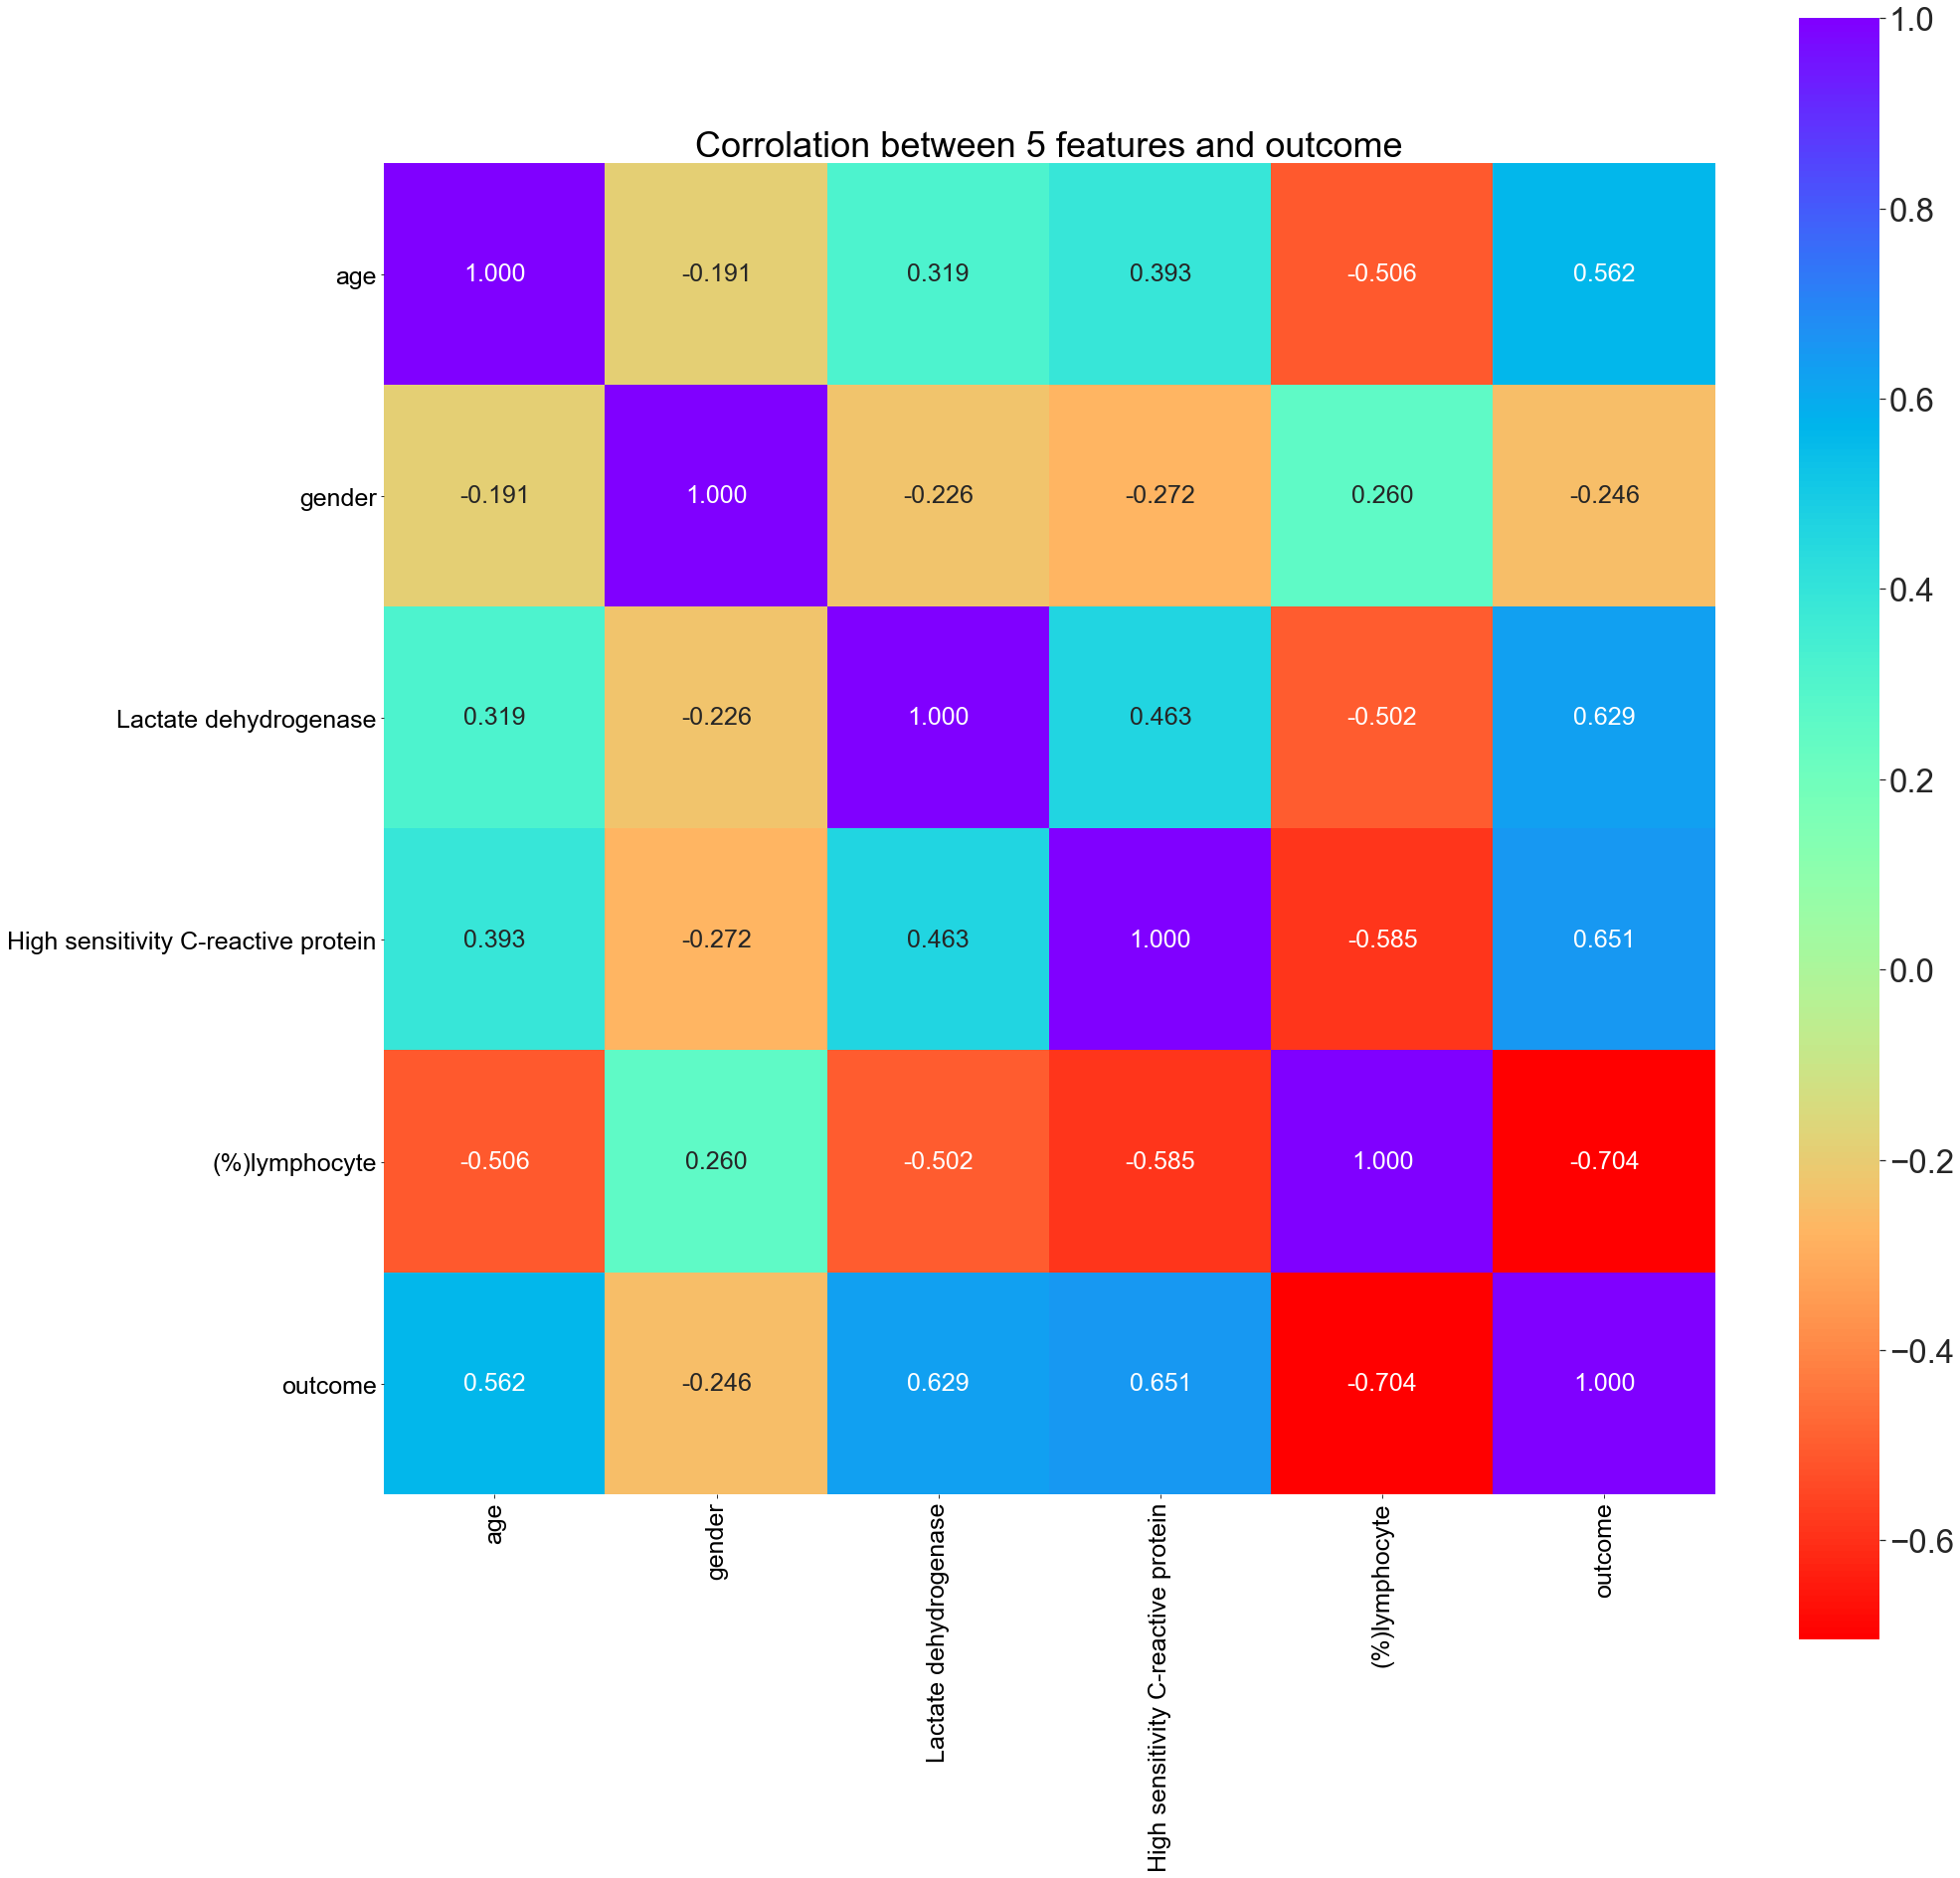

In [109]:
fig,ax = plt.subplots(figsize=(30,30))
cm = newdata.corr()
sns.set(font_scale=3)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='0.3f',annot_kws={'size':25},
                 cmap='rainbow_r',ax=ax,
                 yticklabels=newdata.columns.values,xticklabels=newdata.columns.values)
ax.set_title('Corrolation between 5 features and outcome')
fig.savefig('heatmap.jpeg')
plt.show()

In [ ]:
# x,y = listPlot[i].values.T[:2]
# X,Y = np.meshgrid(x,y)
# Z = 
# plt.rcParams.update({'font.size': 20})
# label = ['M-survial','F-survial','M-death','F-death']
# fig = plt.figure(figsize=(20,20),dpi=300)
# ax = plt.axes(projection='3d')
# ax.contour3D(X,Y,Z)
# ax.set_xlabel(col[2],labelpad=20)
# ax.set_ylabel(col[3],labelpad=20)
# ax.set_zlabel(col[4],labelpad=10)
# ax.set_title('Using three features for gender and its outcome')
# ax.legend()

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    import pdb
    pdb.set_trace()
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)


In [ ]:
from bokeh.plotting import figure, output_file, show

N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = ["#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)]

TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,\
        reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)
p.scatter(x,y,radius=radii,fill_color=colors, fill_alpha=0.6,line_color=None)
output_file("color_scatter.html", title="color_scatter.py example")
show(p)  # open a browser